#Identifying Fraud from Enron Data Set

<em><small>Uirá Caiado. June 21, 2015</small></em>

----------

###Abstract

I explore the public Enron financial and email dataset to identify Enron Employees who may have committed fraud. My goal is to build a machine learning algorithm to solve this chalange.

###Introduction

#####Some Background

According to <a href="https://en.wikipedia.org/wiki/Enron">Wikipedia</a>, Enron was an energy, commodities, and services company that had employed approximately 20,000 staff. It was one of the largest companies in the United States, with claimed revenues of nearly $111 billion during 2000.

Also, it was one of the largest business scandals in American history, falling into bankruptcy in 2001 after was revealed widespread corporate fraud. As pointed out in the Udacity <a href="https://docs.google.com/document/d/10GYepNkDj-Kc_Sf6to3WX_q_SdymPOBJf3H-pq7a62g/pub">project description</a>, in the resulting Federal investigation, there was a significant amount of typically confidential information entered into the public record, including emails and financial data for top executives.

Given that there is a list of people who were somewhat involved in the scandal, here called person of interest (POI), I will try to develop a machine learning algorithm to identify those people with an acceptable accuracy.

##### How I Dealt With This Task

To explore and iterate over each step of this project, I created a bunch of libraries to make my life easier and avoid cluttering this report with too much code. Here is a short description of each library used:

1. __dataset.py__: Load and handle the data used in this project.
2. __eda_new.py__: Explore the dataset and plot some charts. It is used in "Understanding the Dataset" section.
3. __featureSelection.py__: Reshape the data to be used by Sklearn library, engineer new features and select the best ones.
4. __classifiers.py__: Load and train different classifiers from Sklearn library. Uses `validation` library to evaluate each classifier and print a report.
5. __validation.py__: An adapted version of `test_classifier` function from Udacity's `tester` library that implements Sklearn's  `StratifiedShuffleSplit` method to croos-validate the classifier passed.

<br>
In the end of each section, I will test my hypothesis against a baseline that I am going to create below. If it overcomes my current baseline, I will update it with best approach. 

###Building a baseline

##### Creating my first classification model

Thinking about the typical workflow for Machine learning tasks, it could be:

1. Exploring and understanding the input data
2. Cleaning the dataset
3. Analyzing how best to present it to the learning algorithm
4. Choosing the right model and learning algorithm
5. Measuring the performance correctly

As pointed out by the Udacity code reviewer, "Machine Learning can be very iterative". After all, if the chosen algorithm didn't perform well, I will have to execute at least the 3 to 5 steps again.

Let's start by creating a baseline for the next steps. For now, I will use the sklearn's standard implementation of `KNeighbors` algorithm and loop over each step to see which decisions result in better performance. The parameter of the ML method can be seen below:

In [6]:
#exclude it from the final version
import dataset; reload(dataset);
import featureSelection; reload(featureSelection)
import classifiers; reload(classifiers);
o_enron = dataset.LoadEnron()

In [4]:
#use Classifier class from classifiers to load sklearn´s KNeighbors
import classifiers
clf = classifiers.Classifier("KNeighbors", usePCA = False)
clf.clf

Pipeline(steps=[('KNeighbors', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'))])

#####Evaluating it

As mentioned above, one of the core steps in a machine learning task is the evaluation. In the next sessions, I always will report three performance metrics: accuracy, precision and recall. I will discuss the details of each one later. Roughly, __accuracy__ is the fraction of examples that the model classified correctly. The __recall__ is how many POIs were classified from all POIs in the dataset. __Precision__ means that, from all data points classified as POIs, how many were classified correctly. The equation for each metric is:

- __accuracy__: $\left ( TruePositives + TrueNegatives \right )\div \left ( Positives + Negatives \right )$
- __precision__: $\left ( TruePositives \right )\div \left ( TruePositives + FalseNegatives \right )$
- __recall__: $\left ( TruePositives \right )\div \left ( TruePositives + FalsePositives \right )$

Below I am going replace the "NaN" values with zeros using `fill_and_remove` method from `dateset` library. I will test the best approach to filling the missing values later. Then,  I will split the data into a features and labels array using featureSelection's `getFeaturesAndLabels` function. __I won't use 'total_payments' and 'total_stock_value' features because they summarize all other features in my data.__.

Finally, I will cross-validate it using `StratifiedShuffleSplit` with `folds=1000` and `random_state = 42`.  The last one is used to ensure that I will get the same result every time. I will explain why I am using this validation method in the last session.

Here are the metrics for my baseline when using all data avaliable:

In [5]:
#create the objects used thoughout the project
o_features = featureSelection.Features()
#create a list of all features available in the dataset. I am excluding email address because 
#it is a string and poi because it is what I want to predict
l_exclude = ['email_address','poi', 'total_payments', 'total_stock_value']
features_list = [x for x in o_enron.df.columns if x not in l_exclude]
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list, b_remove=False)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['baseline'])

,baseline
accuracy,0.8768
precision,0.6301
recall,0.1840


It was not so bad. Until the end of this report, I should select a machine learning algorithm that presents at least a $precision=0.30$ and a $recall=0.30$.

###Understanding the Dataset

#####Data Exploration

The data set is relatively small, and the number of identified POIs is even smaller. There are 146 different data points, or people, in this collection, but just 18 were classified as POIs. Each data point has 21 features, although more than half of them didn't display any information for 40% or more of all dataset, as shown below.

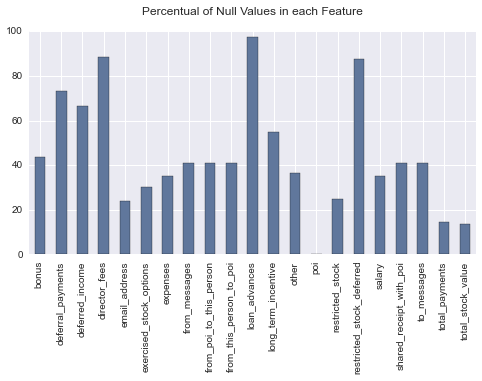

In [9]:
#create and eda instance and plot the percentage of Nans in dataset
import eda_new; reload(eda_new);
o_stats = eda_new.Eda()
o_stats.NanAtFetaures(o_enron);

Related to the features, I can categorize them into four groups:
- *Metadata*: 2 in total. If it is POI and email address. POI is what I want to predicted
- *Payments*: 10 in total. One is the summation and others are Salary, Bonus...
- *Stock Value*: 4 in total. One is also summation. for instance, Restricted stock options, Excercise stock options...
- *Emails*: 5 in total. Examples are "from POI to this person", "from messages"...

According to the documentary [The smartest guys in the room](https://www.youtube.com/watch?v=pRWXW87YrlM), the executives involved in the scandal used to exercise their option positions early. Later I will check if it can be a useful to identify POIs. Also, I will not use the summations in Payments and Stock Value features. Maybe use it to look for outliers or to build new features. Excluding the both features, the POI feature (that is the target) and the email address, it leaves me with 18 features to use.

Despite all the missing data, it still would be complex to analyze all possible correlations between these features. Here is where machine learning (ML) comes to play. Quonting this [book](http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1782161406), ML teaches machines how to carry out tasks by themselves, providing them with a couple of examples.

#####Outlier Investigation

The point here is those examples mentioned. They should be VALID examples if I want to build a good estimator or classifier. Then, first of all, I need to look for outliers. Let's check it by looking some of the features.

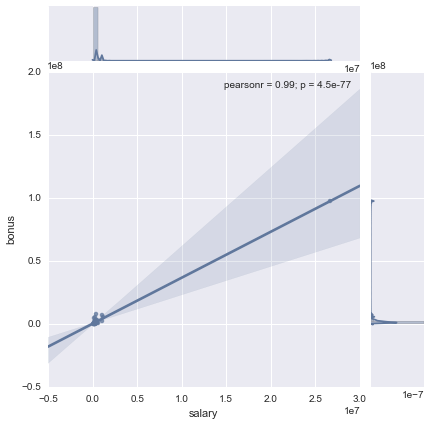

In [342]:
#plot a scatter plot of bonus by salary
o_stats.scatter("salary", "bonus", o_enron)

Here can be easily visualized that there is some data far away from the most of the data points. First, I am going to check who is in the top $10$% of the "salary" feature.


In [343]:
#get the last decile of salary feature
o_stats.getDecile('salary', o_enron)

,salary,poi
TOTAL,26704229,False


Hm... a summation. It is clear invalid. I will exclude this data point and run the scatter plot again 

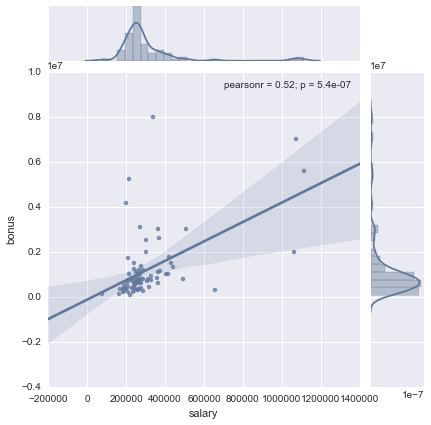

In [10]:
#exclude the data point called "TOTAL" and plot a scatter plot of bonus by salary
o_enron.excludeOutliers(l_outliers =  ["TOTAL"])
o_stats.scatter("salary", "bonus", o_enron)

Much better. Looking at the last decile of each feature, I can see that neither salary or bonus seems hold real outliers. Curiously, the biggest bonus wasn't to a POI.

In [345]:
#get the last decile of salary feature
o_stats.getDecile('salary', o_enron)

,salary,poi
SKILLING JEFFREY K,1111258,True


In [346]:
#get the last decile of bonus feature
o_stats.getDecile('bonus', o_enron)

,bonus,poi
LAVORATO JOHN J,8000000,False


Well... Let's look if there is another outlier. First, I will use the summations to check other features. Any difference between the values I will show in a line called "Delta".

In [347]:
#compare the total_stock_value to sum of all features related to it
df1, df2 = o_stats.checkSummation(o_enron)
#checking Stocks feature
df1

,BELFER ROBERT
poi,0
restricted_stock,0
restricted_stock_deferred,44093
exercised_stock_options,3285
total_stock_value,-44093
Delta,91471


In [348]:
#compare the total_payments to sum of all features related to it
#checking Payments features
df2

,BELFER ROBERT,BHATNAGAR SANJAY
poi,0,0
bonus,0,0
deferral_payments,-102500,0
deferred_income,0,0
director_fees,3285,137864
expenses,0,0
loan_advances,0,0
long_term_incentive,0,0
other,0,137864
salary,0,0


Looking at the enron61702 pdf file, I can see that the differences above are due to some missing information. As it can bias the algorithms and both are non-POIs, I am going to exclude them.

In [11]:
#excludeOutliers excludes the data point in the l_outliers list passed 
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY"])

Ok, let's see if my baseline line algorithm will perform better after these outliers removal: 

In [81]:
#exclude it from the final version
import dataset; reload(dataset);
import featureSelection; reload(featureSelection)
import classifiers; reload(classifiers);
o_enron = dataset.LoadEnron()
clf = classifiers.Classifier("KNeighbors", usePCA = False)
#create the objects used thoughout the project
o_features = featureSelection.Features()

#create a list of all features available in the dataset. I am excluding email address because 
#it is a string and poi because it is what I want to predict
l_exclude = ['email_address','poi', 'total_payments', 'total_stock_value']
features_list = [x for x in o_enron.df.columns if x not in l_exclude]
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list, b_remove=False)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['baseline'])
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])



In [12]:
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list, b_remove=False)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['baseline','outliers_removal'])

,baseline,outliers_removal
accuracy,0.8768,0.8844
precision,0.6301,0.7995
recall,0.1840,0.1775


Interesting. Clearly remove outliers improved the overall performance of my algorithm.

##### Handle Missing Values

As I mentioned before, there are some features that presented numerous missing values. So far, I just filled them with zeros, but there are other options to handle theses cases. I am going to test the impact of two other approaches in the algorithm performance. I am going to use sklearn preprocessing's `Imputer` with `missing_values='NaN'` and `axis=0` when I want to complete missing values with the `strategy=mean` or `strategy=median` and Pandas's index operations when I fill the dataset with zeros. First, I will __fill all "Nan" values with zero, as I did before, and exclude all the data points that all features are qual to zero__ (it is what Udacity code implements).

In [13]:
#exclude it from the final version
import dataset; reload(dataset);
import featureSelection; reload(featureSelection)
import classifiers; reload(classifiers);
o_enron = dataset.LoadEnron()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
clf = classifiers.Classifier("KNeighbors", usePCA = False)
#create the objects used thoughout the project
o_features = featureSelection.Features()

#create a list of all features available in the dataset. I am excluding email address because 
#it is a string and poi because it is what I want to predict
l_exclude = ['email_address','poi', 'total_payments', 'total_stock_value']
features_list = [x for x in o_enron.df.columns if x not in l_exclude]

In [14]:
#exclude it from the final version
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list,s_strategy="zeros", b_remove=False)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['zeros'])

,zeros
accuracy,0.8844
precision,0.7995
recall,0.1775


In [367]:
#exclude it from the final version
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list,s_strategy="zeros", b_remove=True)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['zeros'])

,zeros
accuracy,0.8845
precision,0.7908
recall,0.1815


In [15]:
#create the objects used thoughout the project
o_enron = dataset.LoadEnron()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list,s_strategy="zeros", b_remove=True)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['zeros','zeros-removing'])

,zeros,zeros-removing
accuracy,0.8844,0.8845
precision,0.7995,0.7908
recall,0.1775,0.1815


Hm...it improved my recall. Now, let's check what happens when I interpolate the missing values __with the mean__ of each feature.

In [360]:
#create the objects used thoughout the project
o_enron = dataset.LoadEnron()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list,s_strategy="mean", b_remove=False)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['zeros-removing','mean'])

,zeros-removing,mean
accuracy,0.8845,0.8812
precision,0.7908,0.7057
recall,0.1815,0.1870


Finally, filling the missing values with the median of each feature

In [354]:
#create the objects used thoughout the project
o_enron = dataset.LoadEnron()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list,s_strategy="median", b_remove=False)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list)
#train ML and print a report
clf.crossValidation(features, labels,  report = False, l_columns= ['mean','median'])

,mean,median
accuracy,0.8812,0.8711
precision,0.7057,0.5840
recall,0.1870,0.1165


Filling the missing values with their median wasn't a good idea. And using the mean, it has worsen a lot my precision, then I will keep using `strategy=zeros` with `b_remove=True` to filling missing values in my next steps. Let's a description of all numeric data to see if there is any evidence of another outlier.

In [205]:
#use pandas describe to show a summary of the data
o_stats.describe(o_enron)

,count,mean,std,min,25%,50%,75%,max
bonus,143.00,"1,201,773","1,082,105","70,000","700,000","1,201,773","1,201,773","8,000,000"
deferral_payments,143.00,"867,119","653,224","7,961","867,119","867,119","867,119","6,426,990"
deferred_income,143.00,"-581,050","541,990","-3,504,386","-581,050","-581,050","-581,050",-833
director_fees,143.00,"92,573","10,431","17,500","92,573","92,573","92,573","125,034"
exercised_stock_options,143.00,"2,993,007","4,608,182","9,803","758,429","2,218,275","2,993,007","34,348,384"
expenses,143.00,"54,192","37,314",148,"33,528","54,192","54,192","228,763"
from_messages,143.00,616,"1,424",12,36,616,616,"14,368"
from_poi_to_this_person,143.00,66,67,0,26,66,66,528
from_this_person_to_poi,143.00,42,77,0,6,42,42,609
loan_advances,143.00,"27,975,000","5,504,597","400,000","27,975,000","27,975,000","27,975,000","81,525,000"


Although there are pretty big numbers in the financial information, they are all related to executives from Eron. Now, I have $143$ data points left and I believe that I am done here. 

###Feature Selection and Engineering

#####Creating Features

There are two points that caught my attention in the documentary "The Smartest Guys in The Room". First, some of the top executives used to spend a lot of the firm's money in strip clubs. Second, there were some employees who exercised much of their stock options earlier, knowing about the company's financial conditions. Based on these facts, I will include two more features to be tested:
- Biggest Expenses: I am going to compare the expenses with the salary of each one. Maybe POIs used to spend the money from Enron instead of their own.
- Exercised Stock Option vs. Total of Payment: If a high stake of your money is in a company that you know that is going to crash, what would you do? Sell, sell as much as you can. I will divide the total of stock options that were exercised by the total of money each one has made (I will not consider the remain stock options). I want to know if the amount of options of each POIs were relevant to their saving accounts. 

I will scale alll these features. Below I am going to draw the box plot of each one. I will exclude some outliers just to these visualizations.

In [26]:
#exclude it from the final version
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove(l_features= features_list,s_strategy="zeros", b_remove=True)

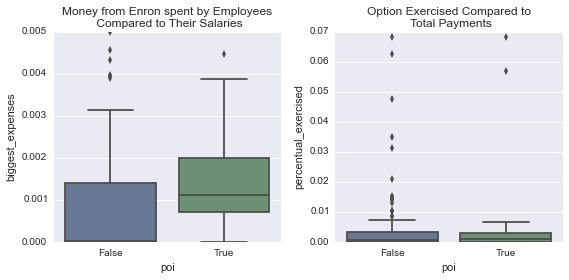

In [27]:
o_features.createNewFeatures(o_enron)
o_stats.compareFeaturesCreated(o_enron)

The Biggest Expenses feature is more dispersed when related to POIs. The second feature, the Option excercised compared to the total payment of each data point, doesn't seem much relevant. Ok, let's see if they can improve my performance.

In [28]:
#create the objects used thoughout the project
o_enron = dataset.LoadEnron()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
#fillna NaNs and reshape the data as numpy arrays
o_enron.fill_and_remove(l_features= features_list,s_strategy="zeros", b_remove=True)

o_features.createNewFeatures(o_enron)
features_list2 = features_list + ['biggest_expenses', 'percentual_exercised']

In [368]:
#create new features
o_features.createNewFeatures(o_enron)
features_list2 = features_list + ['biggest_expenses', 'percentual_exercised']
o_enron.fill_and_remove(l_features= features_list2,s_strategy="zeros", b_remove=True)
labels, features= o_features.getFeaturesAndLabels(o_enron,l_columns = features_list2 )
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = False, scale_on_pipe=False)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['baseline','with new features'])

,baseline,with new features
accuracy,0.8845,0.8845
precision,0.7908,0.7908
recall,0.1815,0.1815


It seems that did not make difference. Maybe when I reduce my feature space , these features can be selected. Let's keep going.

#####Scale or not Scale

As I intend to use the K-means algorithm as one of my machine-learning candidates, usually it is required to scale the data because the algorithm uses the distance between the data points as a measure of similarity between them.

I am going to test two approachs here: First, considering that there are two different units in the features to be tested, money and count of e-mails, I am going to scale each group of features separately, but all features of the same group together.

In [369]:
#scale features according to the total of each group and split them
o_features.scallingAll(o_enron)
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list2, scaled=True)
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = False, scale_on_pipe=False)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['mean','scaled data'])

,mean,scaled data
accuracy,0.8845,0.8469
precision,0.7908,0.1938
recall,0.1815,0.0470


... hm, it is bad...ok, let's see if reducing features to a range between 0 and 1 using sklearn preprocessing's function `MinMaxScaler` can help.

In [370]:
#get data in their normal scale
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = features_list2)
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = False, scale_on_pipe=True)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['mean','sklearn scaled'])

,mean,sklearn scaled
accuracy,0.8845,0.8579
precision,0.7908,0.2471
recall,0.1815,0.0320


I give up. It was definitely not a good idea to scale my dataset. Maybe when I put all features in the same scale, the features that matter in this case are being surpassed by other. Then, I will not scale this data.

#####Should I use features with too little valid data?

In [262]:
#exclude it from the final version
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove(l_features= features_list,s_strategy="mean", b_remove=False)
o_features.createNewFeatures(o_enron)


Now, what features should I use to train my machine learning algorithms? As I discussed before, there are some features that most of the values is equal to "Nan". As I want to examine all features related to emails behaviour, I will cut all those that have presented less than 45% of valid numbers. Below, I presented the $10$ smallest ValidNumber ratios.

In [168]:
o_stats.notValidNumbersTable(o_enron).tail(10)

,ValidNumbers
biggest_expenses,0.554795
from_poi_to_this_person,0.506849
from_this_person_to_poi,0.452055
long_term_incentive,0.452055
deferred_income,0.335616
deferral_payments,0.267123
poi,0.123288
restricted_stock_deferred,0.123288
director_fees,0.116438
loan_advances,0.027397


Corrigir função de notvalid numbers....ela é afetada por não preencher mais com zeros. Talvez deva manter dados originais

In [263]:
l_precision=[]
l_recall=[]
l_val = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#get data in their normal scale
for f_val in l_val:
    labels, features= o_features.getFeaturesAndLabels(o_enron, o_eda = o_stats, f_validNumMin=f_val)
    #create a new classifier object with minmaxscaler in its pipeline
    clf2 = classifiers.Classifier("KNeighbors", usePCA = False, scale_on_pipe=False)
    clf2.d_performance = clf.d_performance
    #train ML and print a report
    clf2.crossValidation(features, labels,  report = False, l_columns= ['mean','sklearn scaled'])
    l_precision.append(clf2.d_performance["precision"])
    l_recall.append(clf2.d_performance["recall"])

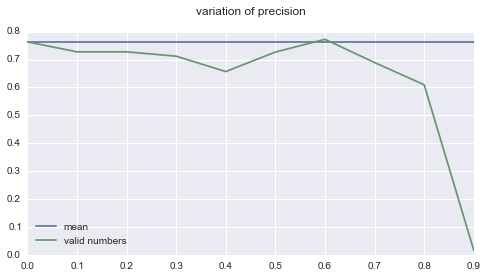

In [269]:
ax = pd.DataFrame([[clf.d_performance["precision"]] * len(l_precision), l_precision], columns = l_val,
             index = ["mean", "valid numbers"]).T.plot()
ax.set_title("variation of precision\n");

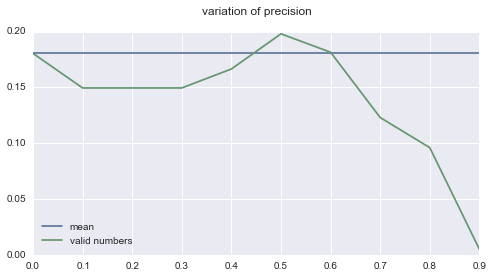

In [271]:
ax = pd.DataFrame([[clf.d_performance["recall"]] * len(l_recall), l_recall], columns = l_val,
             index = ["mean", "valid numbers"]).T.plot()
ax.set_title("variation of precision\n");

In [233]:
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns=features_list, o_eda = o_stats, f_validNumMin=0)
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = False, scale_on_pipe=False)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['mean','sklearn scaled'])

,mean,sklearn scaled
accuracy,0.8833,0.8833
precision,0.7632,0.7632
recall,0.1805,0.1805


#####Selecting the best ones

I am going to select features using sklearn's `SelectPercentile` with ANOVA F-test function to score the features. Let's see what percentile can maximize my performance.

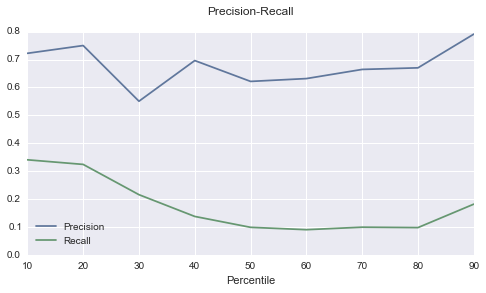

In [435]:
eda_new.precision_recall_curve(dataset.LoadEnron, classifiers.Classifier, o_features, features_list2)

Interesting. The best recall occurred at the top $10%$ percentile, but in the top $20%$ I hit greater precision with slightly smaller recall. The greater precision occurred at $90%$ at the cost of a recall smaller than $0.20$. Then I will use the select percentile function with `percentile=20`. Here are the features represented by the top 20%.

In [30]:
#exclude it from the final version
labels, features= o_features.getFeaturesAndLabels(o_enron, o_stats,l_columns = features_list2)

In [31]:
l_selectedFetures, df_rtn = o_features.select(features, labels, features_list2, percentile=20)
"features selected: {}".format(l_selectedFetures)

"features selected: ['bonus', 'deferred_income', 'exercised_stock_options', 'salary']"

Just Payment and Stock Value features. No Email or New features. Below is the rank of all features based on the biggest p-value.

In [375]:
df_rtn

,pValue_Max
exercised_stock_options,1.000000
bonus,0.857466
salary,0.769350
deferred_income,0.525508
long_term_incentive,0.466340
percentual_exercised,0.444304
restricted_stock,0.436342
shared_receipt_with_poi,0.416612
loan_advances,0.362126
expenses,0.314408


Ow...one last thing. As I will use just some features in the next section, I am going to remove any data point that __all the selected features__ are equal to $0$. 

In [32]:
o_enron.fill_and_remove(l_features= l_selectedFetures)

Now, let's see if it improved my algorithm

In [44]:
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns=l_selectedFetures , o_eda = o_stats)
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = False, scale_on_pipe=False)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['baseline','features selected'])

,baseline,features selected
accuracy,0.8845,0.8880
precision,0.7908,0.7500
recall,0.1815,0.3240


As I could see in the chart, I hit a recall bigger than $0.30$ at the cost of just a little of precision. After this last cleaning, I just have $131$ data points left. 

###Pick and Tune an Algorithm

In [2]:
#exclude it from the final version
import eda_new; reload(eda_new);
import dataset; reload(dataset);
import featureSelection; reload(featureSelection);

o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()
o_features = featureSelection.Features()
o_enron.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
o_enron.fill_and_remove()
o_features.createNewFeatures(o_enron)
o_features.scallingAll(o_enron)

features_list = o_features.getFeaturesList(o_enron, o_stats,f_validNumMin=0.45)
labels, features= o_features.getFeaturesAndLabels(o_enron, o_stats,f_validNumMin = 0.45)
l_selectedFetures, df_rtn = o_features.select(features, labels, features_list)
o_enron.fill_and_remove(l_features= l_selectedFetures)
#selecgtinn everything again
labels, features= o_features.getFeaturesAndLabels(o_enron, o_stats,f_validNumMin = 0.45, l_columns = l_selectedFetures)
labels_scaled, features_scaled  = o_features.getFeaturesAndLabels(o_enron, o_stats,scaled=True, f_validNumMin = 0.45, l_columns = l_selectedFetures)

#####Using or not using PCA

I would like to test one last thing before selecting and tuning an algorithm. Below, I am going to test the effect of using PCA in my baseline. As this method usually requires some kind of standardization, I will include the  sklearn preprocessing's `StandardScaler`to my pipeline.

In [45]:
#exclude
clf = clf2

In [46]:
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns=l_selectedFetures , o_eda = o_stats)
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = True, standardize=True)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['baseline','pca standardized'])

,baseline,pca standardized
accuracy,0.8880,0.8499
precision,0.7500,0.3750
recall,0.3240,0.0765


....It was bad. Ok, and without using the standardization

In [47]:
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns=l_selectedFetures , o_eda = o_stats)
#create a new classifier object with minmaxscaler in its pipeline
clf2 = classifiers.Classifier("KNeighbors", usePCA = True, standardize=False)
clf2.d_performance = clf.d_performance
#train ML and print a report
clf2.crossValidation(features, labels,  report = False, l_columns= ['baseline','pca'])

,baseline,pca
accuracy,0.8880,0.8880
precision,0.7500,0.7500
recall,0.3240,0.3240


It didn't make any difference in my current baseline. I believe that, as I am using just features related to money, in fact, I don't have to scale this data. Well, as I am not sure about the effect of the PCA in the other algorithms that I am going to test, I will keep using it in the next steps

#####Selecting an Algorithm

Here is the deal. I must find the best machine learning algorithm to identify who has committed fraud, given the features selected. I am going to train different classifiers methods to see how each one performs. Also, I will use Principal component analysis (`PCA`) to project my features space into a even lower dimensional space. Let's start by looking at the __Navie Bayes Classifier__: 

In [ ]:
#exclude it from the final version
import classifiers; reload(classifiers);
labels, features= o_features.getFeaturesAndLabels(o_enron, l_columns = l_selectedFetures, o_eda = o_stats)
o_all = classifiers.MLMethods()
df_rtn  = o_all.crossValidationAll(features, labels)

In [389]:
o_all.getReport("crossValidation","GaussianNB")


Classifier Used
------------------
Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=None, whiten=False)), ('GaussianNB', GaussianNB())])

Classification Report
------------------
Accuracy: 0.86200	Precision: 0.52556	Recall: 0.34950	F1: 0.41982	F2: 0.37460

Confusion Matrix
------------------
Total predictions: 14000	True positives:  699	False positives:  631
				False negatives: 1301	True negatives: 11369



I know... What are these $14,000$ of total predictions? Didn't I say that I had just $131$ data points? As Udacity suggested, I am cross-validating the algorithm by stratifying the data set into randomized folds. Each fold is made by [preserving the percentage](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html) of samples for each class and presents 131 data points. I will explain it better in the next section.

Despite the more than 85% of accuracy above, it is not a great outcome. Looking at the confusion matrix, it is clearer why it isn't. When the Naive Bayes classified not POIs instances, it has achieved a nice proportion, 11,400 correct for 1,300 incorrect. When used to classify POIs instances, it almost tossed a coin. Unfortunately, POIs are what I am interested. I believe the problem here is that the data set has much more negative instances than positive ones.

According to the [book](http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1782161406) "Building Machine Learning Systems With Python", I have the following options to improve my current performance:
- Add more data
- Play with the model complexity
- Modify the feature space
- Change the model

Well, adding more data is impossible. Then, let's start by changing the model. I am going to display a summary of the performance metrics for six different classifiers tested. The dataframe below was created using the classifiers MLMethods'method `crossValidationAll` that was created for this study. It runs the Udacity's Cross-validation test using sklearn `StratifiedShuffleSplit`for all machine learning methods stored in an internal dictionary.

In [390]:
df_rtn

,accuracy,precision,recall
SVM,None,None,None
RandomForest,0.8413,0.3965,0.2125
GaussianNB,0.8620,0.5256,0.3495
DecisionTree,0.8033,0.3022,0.2880
AdaBoost,0.8231,0.3444,0.2640
KNeighbors,0.8880,0.7500,0.3240


Selecting the best one isn't easy. As an I have explained before, I can't just pick the estimator that had the best accuracy. I should choose the classifier that best fits in my goal. For now, believe me, __the best algorithm is my baseline, the KNeighbors__.

As shown above, I also tested SVM algorithm despite it has returned "divide by zero" error for all setups used in the cross-validation step. It is related to the size of each fold and the number of positive examples. It seems that the SVM had a hard time using such imbalanced available data.

Well, before I decide by a specific algorithm, in the next section I will play with the models complexity.

#####Tuning the classifiers

Another way to improve my performance is by playing with the model complexity. According to this [blog post](http://machinelearningmastery.com/how-to-improve-machine-learning-results/), as machine learning models are parameterized, their behavior can be modified by tuning their parameters for a given problem.  It can lead to better estimators... or not. The more tuned, higher is the risk of overfitting. This strategy can be effective, but it can also result in a more fragile models that don’t perform well in practice.

I am going to use the method `GridSearchCV` to tune my classifiers. It looks for the best set of parameters between candidates generated from a grid of parameter values. The best here was defined as the accuracy of each ML model.

In [398]:
from sklearn.grid_search import GridSearchCV

In [399]:
GridSearchCV?

In [ ]:
df_rtn  = o_all.gridSearchAll(features, labels)
df_rtn.iloc[1:,:]

Looking solely to the accuracy of each model, the best were RandomForest and KNeighbors again. I still need to cross-validate each algorithm to choose the best one. The set o parameters that implied in the highest accuracy to each one were:

In [ ]:
o_all.getReport("GridSearch", "KNeighbors")

In [ ]:
o_all.getReport("crossValidation", "KNeighbors")

In [7]:
o_all.getReport("GridSearch", "KNeighbors")

Best Score: 0.8607

PARAMETERS TESTED
------------------
{'KNeighbors__n_neighbors': [2, 3, 4, 10, 30],
 'KNeighbors__p': [1, 2, 3],
 'reduce_dim__n_components': [1, 2, 3]}

BEST PARAMETER
------------------
{'KNeighbors__n_neighbors': 4,
 'KNeighbors__p': 2,
 'reduce_dim__n_components': 2}




###Validate and Evaluate

#####Usage of Evaluation Metrics and Validation Strategy

The core objective of a machine learning algorithm is to generalize correctly from its experience when facing new instances. In other words, what matters in any estimator is the ability of the model to generalize to new cases. 

Here is where validation strategy comes into play. If I use the same data used to train the model to evaluate it, for sure that it will perform well. The logic is circular. What I really need to do is measuring the algorithm performance in instances that it has not seen at training. 

As pointed out by the book "Building Machine Learning Systems with Python", measuring the performance also is the part where most mistakes are waiting for aspiring ML learner. There are easy ones, such testing your approach with the same data on which you have trained. But there are more difficult ones; for example, when you have imbalanced training data.

To address the first case, I am going break up the data into two blocks: on one block, I will train the model, and on the other, what I held out of training, I will test it. Due to the small size of the dataset, I will shuffle the data and repeat this process 1,000 times. As I have explained before, each run will preserve the percentage of samples for each class in both blocks.

Due to the imbalance data, I will look at precision and recall instead of focus on accuracy. The point is what I am trying to achieve here. I don't need a classifier that is good in predicting POIs AND not POIs, what is measured by __accuracy__. 

I need a classifier with acceptable performance when predicting POIs. Also, it is OK if the classifier miss some POIs (__recall__) since I can trust when my algorithm blame someone of being POI (__precision__).

Then, to summarizing my strategy so far:

1. I excluded the points "BELFER ROBERT","BHATNAGAR SANJAY" and "TOTAL" from the dataset.
2. I filled the missing values with the zeros and exclude features that presented just zeros in all features
3. I did NOT scale the data in any way
4. I selected features in the top 20% percentile: _['bonus', 'deferred_income', 'exercised_stock_options', 'salary']_
5. I included PCA as the first step in my pipeline
6. I tuned my classifiers using `GridSeachCV`
7. I validated all steps using croos-validation with `StratifiedShuffleSplit`

In the next section, I will use all these performance measurements to select one of the algorithms.

#####Algorithm Performance

As I have said, beyond the accuracy, I need explore in the precision/recall from each algorithm to evaluate them properly. Bellow, I am going to show how each classifier performed according to the validation startegy:

In [8]:
df_rtn  = o_all.crossValidationAll(features_scaled, labels_scaled)
df_rtn

,accuracy,precision,recall
SVM,None,None,None
RandomForest,0.8738,0.6979,0.3165
GaussianNB,0.8542,0.5533,0.2725
DecisionTree,0.8608,0.5798,0.3470
AdaBoost,0.8445,0.4927,0.3530
KNeighbors,0.8815,0.7771,0.3225


Looking just to the accuracy, It seems that all classifiers did well ($accuracy>0.80$). KNeighbors and RandomForest, for example, were correct in 87% and 88% respectively of all cases they predicted. But these numbers also are influenced by not-POIs examples. 

Looking at the precision and recall, that accounts the information I am interested in, the performance of the classifiers wasn't so good.

All algorithms missed the most of the data points classified as POIs. The DecisionTree presented the best recall score, predicting almost 40% of all POIs in the dataset. For another side, when it classified someone as being a POI, it was right just in 57% of the cases. I am not looking for this kind of behavior.

Although KNeighbors didn't presented a great recall, labeling just 32% of all true cases, when it classified someone as being a POI, the estimator was right almost in 78% of the cases. In this way, given the size of this dataset, I believe that the __KNeighbors is the best classifier__ for this task. Bellow I am going to show the cross-validation report for this algorithm:

In [9]:
o_all.getReport("crossValidation","KNeighbors")

!!!!ALREADY TUNED

Classifier Used
------------------
Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=2, whiten=False)), ('KNeighbors', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=4, p=2, weights='uniform'))])

Classification Report
------------------
Accuracy: 0.88154	Precision: 0.77711	Recall: 0.32250	F1: 0.45583	F2: 0.36523

Confusion Matrix
------------------
Total predictions: 13000	True positives:  645	False positives:  185
				False negatives: 1355	True negatives: 10815



###Reflection

That was a tough ride, from cleaning this imbalanced and small dataset to made an informed decision about which algorithm to use for the task. I learned about cross-validation, what is behind the accuracy and the different steps to follow in a machine learning problem.

Along the way, I also learned how to use some convenient tools from Scikit-learn. For example, I used `SelectPercentile` to help me select the best features based on the percentile of their scores. I used `Pipeline` to execute `PCA` before each algorithm tested. I used `GridSeachCV` to create a grid of different parameters and evaluate the classifiers according each configuration. I used `StratifiedShuffleSplit` to cross-validate such small and imbalanced dataset. As I wanted as many true positives as possible, I ended up selecting `KNeighborsClassifier` to the task due to its precision score.

Finally, I also learned the importance of correctly modeling your data set. As I adapted many of the Udacity codes to run this project in this notebook, I made many mistakes when importing and cleaning the dataset, what leaded me to very different results that I was expecting initially.

Eu otimizei cada etapa para um algoritimo que eu escolhi arbitrariamente. Talvez pudesse ter feito isso de outro maneira, mas quis contruir uma narrativa de como fui melhorando a performance do meu algo.

Testar cada escolha feita dá trabalho

Aprendi da pior maneira que é melhor deixar cada passo da minha pesquisa bem dividida para não ter que ficar loadando os dados toda hora.

####TODO:


<hr>
<em><p>7/14/2015 - At least 2 different algorithms attempted, and their performance is compared with the more performant one used in the final analysis</p>
<p>7/14/2015 - Precision and recall are used to evaluate algorithm performance</p>
<p>7/12/2015 - How do I interpret the PCA components? what features is it been using?</p>
<p>7/11/2015 - At least 2 different algorithms attempted, and their performance is compared with the more performant one used in the final analysis</p>
<p>7/11/2015 - What algorithm did you end up using?</p>
<p>7/6/2015 - If you used an algorithm like a decision tree, please also give the feature importances of the features that you use.</p>
<p>7/13/2015 - [Precision Recall] ... student articulates what those metrics measure.</p>
<p>7/13/2015 - Response addresses what validation is and why it is important.</p>
<p>7/13/2015 - Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance</p>
<p>7/13/2015 - How did you validate your analysis?</p>
<p>7/13/2015 - What is validation, and what’s a classic mistake you can make if you do it wrong?</p>
<p>7/12/2015 - the effect of features created on the final algorithm performance is tested.</p>
<p>7/12/2015 - At least one important parameter tuned, with at least 3 settings investigated; or any of the following are true: GridCV used for parameter tuning; Several parameters tuned ; Parameter tuning incorporated into algorithm selection (i.e. parameters tuned for more than one algorithm, and best algorithm-tune combination selected for final analysis)</p>
<p>7/12/2015 - How did you tune the parameters of your particular algorithm?  (Some algorithms don’t have parameters that you need to tune--if this is the case for the one you picked, identify and briefly explain how you would have done it if you used, say, a decision tree classifier).</p>
<p>7/12/2015 - Give at least 2 evaluation metrics, and your average performance for each of them.</p>
<p>7/12/2015 - What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?</p>
<p>7/12/2015 - Response addresses what it means to perform parameter tuning and why it is important.</p>
<p>7/10/2015 - What other one(s) did you try?</p>
<p>7/10/2015 - The data is split into training and testing sets, with the testing data used for assessing overall analysis performance; or k-fold cross validation is deployed </p>
<p>7/10/2015 - Create a table with all APR of the algos tested. Show the complete report just for the algo choose</p>
<p>7/9/2015 - Insert time to run the ML algos</p>
<p>6/27/2015 - Keep the statistic summary as attribute and include the features selected and the bigger p_value ratio as new columns. Use it to present the results, sorted by p_values. From stats, show just count and the mean to justify the scaling</p>
<p>7/5/2015 - What features did you end up using in your POI identifier, and what selection process did you use to pick them?  </p>
<p>7/4/2015 - Did you have to do any scaling? Why or why not?</p>
<p>6/30/2015 - Add a ratio of exercise stock options and total stock options. Justify by the movie. Maybe show a chart to answer why try it</p>
<p>7/3/2015 - As part of the assignment, you should attempt to engineer your own feature that doesn’t come ready-made in the dataset--explain what feature you tried to make, and the rationale behind it.  (You do not necessarily have to use it in the final analysis, only engineer and test it.) </p>
<p>6/27/2015 - Compare the summation of Payment and Stocks Features to see if all if correctly filled</p>
<p>6/26/2015 - probably is someone important....I could plot a heat map with all datapointsand from to_poi features, splitting it between POIs and non-POIS...in another section - will be not necessary</p>
</em>

<em>Custom CSS</em>

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read() )

In [8]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("darkgrid")

In [27]:
import eda_new; reload(eda_new);
import dataset; reload(dataset);
o_enron = dataset.LoadEnron()
o_stats = eda_new.Eda()

In [43]:
import eda; reload(eda);
stats = eda.Eda()